# Global AI Big Data Conference Presentation

### This is used as a demo file for Global AI/Big Data Conference presentation - on Sept 16th 2020 - to discuss some of the aspects of GPU training of NLP models using PyTorch.

# Agenda

> 1. Background & Expectations
> 2. Quick overview of the GPU platform I am using for the demo - trainml.ai
> 3. Hyperparameters & Training
> 4. Options to check while the model is training
> 5. Memory management
> 6. Some experimental data
> 7. Final Thoughts
> 8. Overview of Trainml.ai platform and special offer for attendees
> 9. Offer for attendees





# 1. Background & Expectations
> - This is the original file from minGPT - but have added sections to specifically discuss about GPU training aspects and some of the challenges. gptMin code base is used as back drop in doing this demo. This is the original repo - https://github.com/karpathy/minGPT

> - So, I will use this code base to "train" a min GPT model BUT please note that I will not able to complete the training - as each such training will take upwards of 15 mins and I only 30 mins to do this demo. So, I will keep starting and stopping the training to demonstrates aspect you all need to be aware of when doing GPU training. 

> - Also, I only discuss play_char.ipynb - which trains a GPT to be a character-level language model on arbitrary text, similar to Karpathy's older char-rnn but with a transformer instead of an RNN

> - Since minGPT uses PyTorch, all my commands and examples are limited to PyTorch and may or may not apply to other libraries such as TensorFlow, Keras, etc. 


# 2. Overview of GPU Platform - What to look for when choosing/picking a platform. 
### I will share more about the platform at the end of this demo and also I have surprise promotion - that will only work after we complete the demo. 
> - Ease of use
> - Transparent pricing
> - Cheaper for experimentation
> - Ideal for starting small and progressively increasing your infrastructure footprint

## Train a character-level GPT on some text data

The inputs here are simple text files, which we chop up to individual characters and then train GPT on. So you could say this is a char-transformer instead of a char-rnn. Doesn't quite roll off the tongue as well. In this example we will feed it some Shakespeare, which we'll get it to predict character-level.

In [21]:
# set up logging

## Tip - The logging module uses handlers attached to loggers to decide how, where, or even if messages ultimately get 
## stored or displayed. You can configure logging by default to write to a file as well.

import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [22]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [23]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [24]:
import math
from torch.utils.data import Dataset

class CharDataset(Dataset):

    def __init__(self, data, block_size):
        chars = sorted(list(set(data)))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d characters, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
    
    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx + self.block_size + 1]
        # encode every character to an integer
        dix = [self.stoi[s] for s in chunk]
        """
        arrange data and targets so that the first i elements of x
        will be asked to predict the i-th element of y. Notice that
        the eventual language model will actually make block_size
        individual predictions at the same time based on this data,
        so we are being clever and amortizing the cost of the forward
        pass of the network. So for example if block_size is 4, then
        we could e.g. sample a chunk of text "hello", the integers in
        x will correspond to "hell" and in y will be "ello". This will
        then actually "multitask" 4 separate examples at the same time
        in the language model:
        - given just "h", please predict "e" as next
        - given "he" please predict "l" next
        - given "hel" predict "l" next
        - given "hell" predict "o" next
        
        In addition, because the DataLoader will create batches of examples,
        every forward/backward pass during traning will simultaneously train
        a LOT of predictions, amortizing a lot of computation. In particular,
        for a batched input of integers X (B, T) where B is batch size and
        T is block_size and Y (B, T), the network will during training be
        simultaneously training to make B*T predictions, all at once! Of course,
        at test time we can paralellize across batch B, but unlike during training
        we cannot parallelize across the time dimension T - we have to run
        a forward pass of the network to recover the next single character of the 
        sequence along each batch dimension, and repeatedly always feed in a next
        character to get the next one.
        
        So yes there is a big asymmetry between train/test time of autoregressive
        models. During training we can go B*T at a time with every forward pass,
        but during test time we can only go B at a time, T times, with T forward 
        passes.
        """
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y


In [25]:
# Tip - Language model will actually make block_size individual predictions at the same time based on this data
# This is used in TrainerConfig, GPTConfig & CharDataset as well
    
block_size = 128 # 128 spatial extent of the model for its context

In [7]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2020-09-12 23:14:38--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.128.133, 151.101.0.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.07s   

2020-09-12 23:14:38 (15.7 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [26]:
# you can download this file at https://github.com/karpathy/char-rnn/blob/master/data/tinyshakespeare/input.txt
text = open('input.txt', 'r').read() # don't worry we won't run out of file handles
train_dataset = CharDataset(text, block_size) # one line of poem is roughly 50 characters

data has 1115394 characters, 65 unique.


# 3. Hyperparameters & Training
> This is a quick overview of only some of the hyperparameters that will directly or indirectly impact your training duration, GPU memory utilization, etc. 

### 1. Epochs 

> Usually the training takes several passes (epochs). Too few epochs can lead to underfit, and too many to overfit. Also depends complexity of the network and problem you are trying to train, but once we have our network configured, we can keep track on both training and testing datasets of the loss along the epochs in order to get an idea of when to stop training.

### 2. Batch size  

> The batch size is the number of samples (e.g. images) used to train a model before updating its trainable model variables — the weights and biases. This is one of the parameters that that impacts memory utilizations. Also has an impact on the resulting accuracy of models, as well as on the performance of the training process.

>> Different neural networks and different datasets may have different optimal batch sizes.

>> Size of neural network is indirectly proportional to Batch size it can support

>>> Note there are some techniques such as Gradient accumulation to help with this challenge. 


### 3. Number of layers - 8 and number of heads is 8 and embeddings - word/token is 512. 
> As compared to say """ GPT-1 like network roughly 125M params """

    >>> n_layer = 12
    
    >>> n_head = 12
    
    >>> n_embd = 768
    
### 4. Number of Features/attributes of your data

In [27]:
from mingpt.model import GPT, GPTConfig
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=512)
model = GPT(mconf)

09/16/2020 21:04:52 - INFO - mingpt.model -   number of parameters: 2.535219e+07


In [14]:
# approximately, 25 Million parameters

In [ ]:
from mingpt.trainer import Trainer, TrainerConfig

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=1, batch_size=512, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*block_size,
                      num_workers=16)
trainer = Trainer(model, train_dataset, None, tconf)
trainer.train()

# 4. Options to check while the model is training
> - <code>Top</code> and <code> Htop </code>

> For example, in terminal you can try <code> top </code> or <code> htop</code>

> Note about <code> top </code> - By default, top displays CPU usage as a percentage of a single CPU. On multi-core systems, you can see percentages of CPU usage are greater than 100%. You can toggle this behavior by hitting Shift + i while top is running to show the overall percentage of available CPUs in use.

> To install <code> htop </code>, run <code> apt-get install htop </code>

> - <code> nvidia-smi</code> and <code> nvidia-smi -a</code> 

>> Memory-Usage: This is the memory allocation on GPU out of total memory. For GPUs with Tensorflow or Keras, automatically allocates whole memory when getting launched, even though it doesn’t require.

>> GPU-Util: This is the percent of GPU utilization - percent of time when kernels were using GPU. 

>> Compute M.: Compute Mode of specific GPU refers to the shared access mode where compute mode sets to default after each reboot. “Default” value allows multiple clients to access CPU at a same time.

>> Disp.A: Display Active is a flag which decides if you want to allocate memory on GPU device for display i.e. to initialize the display on GPU. Here, “Off” indicates that there isn’t any display using GPU device.



# 5. Memory Management

> What gets stored in GPU memory?

>> Model Parameters - Weights & Biases

>> Optimizer Variables

>> Intermediate Data

>> Local variables/Kernel implementation details



### Few points to note
> - Understanding of the health and status of GPU infrastructure has always been very difficult. Also difficult to determine the type and capabilities of the GPUs in a system. So, start with something simple and scale. Crawl before you walk. 

> - This is the most important aspect of GPU training. This is a very involved topic - lot more than what we can cover in 1/2 hr session
> - Each GPU vendor provides their own commandline utilities and each of the libraries such a PyTorch,Keras, Tensorflow provide their own packages to help manage your memory footprint. This is where you can get the maximum bang for your nuck

### 1. torch methods - torch.cuda.empty_cache()
#### - torch.cuda.empty_cache()
> - Releases all unoccupied cached memory currently held by the caching allocator so that those can be used in other GPU application and visible in nvidia-smi.

### PyTorch uses a caching memory allocator to speed up memory allocations. This allows fast memory deallocation without device synchronizations. However, the unused memory managed by the allocator will still show as if used in nvidia-smi. 

#### - torch.cuda.memory_stats(#device_number)
> - Returns a dictionary of CUDA memory allocator statistics for a given device.
The return value of this function is a dictionary of statistics

#### - memory_allocated, memory_cached, max_memory

> -  You can use memory_allocated() and max_memory_allocated() to monitor memory occupied by tensors, and use memory_cached() and max_memory_cached() to monitor memory managed by the caching allocator. 

> -  Calling empty_cache() releases all unused cached memory from PyTorch so that those can be used by other GPU applications. However, the occupied GPU memory by tensors will not be freed so it can not increase the amount of GPU memory available for PyTorch.

> But note that these utilities don’t really you give you the complete memory utilization - for example, this doesn’t take into account of cuda related memory usage - cuda ctx, cuda rng state, cudnn ctx, cufft plans, and other gpu memory your other libraries


## Out of memory (CUDA OOM, etc)
> - When running multiple processes - GPU memory is blocked by the initial process and the next process that is running doens’t have access to that memory block …... Easiest way to deal with this is to “shutdown the previous kernel” using your Jupyter notebook interface and restart the new kernel/process. But this is not a scalable option

> - The GPU, on the other hand, doesn’t release its memory after model training. So training specific variables, such as the momentum values for the Adam optimizer (two variables for every model parameter), stay in memory. As a result, there’s much less memory left for evaluation. To fix the out-of-memory error, we use a smaller validation batch size

> - TPU (in colab) Works differently - The reason is that the TPU is in a pod somewhere else, unlike the GPU, which is inside Colab’s machine or your TPU cluster. So, to use the TPU, we have to access it through the network. After training our model, the TPU is disconnected and closed, and its memory is cleared. When we evaluate the model, we re-connect to the TPU, which has a clean memory, which is sufficient to hold the entire validation set.


In [ ]:
torch.cuda.memory_stats(1)

In [17]:
torch.cuda.max_memory_cached(0)
# 2 GPUs max_memory_cached(0) is 7637827584
# div by 10e9 to GB

6952058880

In [18]:
torch.cuda.max_memory_allocated(0)
# 2 GPUs max_memory_allocated(0) = 7621877760

6806414848

In [7]:
torch.cuda.memory_allocated(0)
# 2 GPUs cuda.memory_allocated(0)= 417400320

0

In [8]:
torch.cuda.memory_cached(0)
# 2 GPUs cuda.memory_cached(0) = 7054819328

0

In [9]:
# cached minus allocated free memory
torch.cuda.memory_cached(0) - torch.cuda.memory_allocated(0)

0

In [ ]:
# Tip - This script looks up memory usage across all the gpu machines
# courtesy of mjstevens777 Matt
# In here, we are nvidia-smi programmatically ....

import subprocess

def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map
get_gpu_memory_map()
#{0: 7326, 1: 6992, 2: 6992, 3: 6992}

In [11]:
!pip install psutil

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:

import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

In [73]:
# gc.collect returns number of unreachable objects. 
# It's really the sum of two numbers: the number of objects that were identified as 
# garbage and actually freed, plus the number of objects that were identified as garbage but could not be freed.

gc.collect()

22

In [12]:
# make sure you run this pip install pynvml

from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

# total    : 8370061312
# free     : 687865856
# used     : 7682195456
    

total    : 11554717696
free     : 11542855680
used     : 11862016


In [10]:
# torch.cuda.empty_cache() will release all the GPU memory cache that can be freed.....can be freed ....
# So, the variables no longer referenced will be freed by using torch.cuda.empty_cache()

torch.cuda.empty_cache()

In [14]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=f1e403e747190845709b0aa05d81daef0f605459cf32dd7dbc5fb13a8b980057
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
# run nvidia-smi
# run nvidia-smi -a - for detailed log of all the stats

# If you want to programmatically pull the data that you see in nvidia-smi, here's one way of doing that

# make sure to install GPUtil before running this utility

import torch
from GPUtil import showUtilization as gpu_usage

print("GPU Usage")
gpu_usage(all=True)                             


In [ ]:
print("GPU Usage after emptying the cache")
torch.cuda.empty_cache()
gpu_usage(all=True)

In [78]:
# torch.cuda.empty_cache() deletes unused tensor from the cache, but the cache itself still uses some memory.
# PyTorch's caching allocator reserves some fixed amount of memory even if there are no tensors, 
# and this allocation is triggered by the first CUDA memory access 


In [ ]:
# better to run this in terminal
!watch -n 1 free -m

In [29]:
# how to check your GPU device names
torch.cuda.get_device_name()

'GeForce RTX 2080 Ti'

In [ ]:
#Tracking Memory Usage with GPUtil


!pip install GPUtil
import GPUtil
GPUtil.showUtilization()

# 6. Some experimental data when trying different number of GPU machines and batch sizes

## GPU Type and number of instances - 
> -  'GeForce RTX 2080 Ti' - 1 instance - batch size 512
> -  CUDA OOM; Tried to allocate 256.00 MiB (GPU 0; 10.76 GiB total capacity; 9.76 GiB already allocated; 135.12 MiB free; 9.87 GiB reserved in total by PyTorch)

> -  'GeForce RTX 2080 Ti' - 1 instance - batch size 256
> -  CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 10.76 GiB total capacity; 9.96 GiB already allocated; 5.12 MiB free; 9.99 GiB reserved in total by PyTorch)

> - 'GeForce RTX 2080 Ti' - 1 instance - batch size 128
> -  CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.76 GiB total capacity; 9.99 GiB already allocated; 5.12 MiB free; 9.99 GiB reserved in total by PyTorch)

> -  'GeForce RTX 2080 Ti' - 1 instance - batch size 64
> - Runs

> -  'GeForce RTX 2080 Ti' - 2 instance - batch size 128
> -  Runs

> -  'GeForce RTX 2080 Ti' - 2 instance - batch size 256
> -  CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 10.76 GiB total capacity; 9.89 GiB already allocated; 95.12 MiB free; 9.90 GiB reserved in total by PyTorch)

> -  'GeForce RTX 2080 Ti' - 4 instances - batch size 256 - 1 epochs - 18 mins
> -  Runs Train loss - 0.23094
 

> - 'GeForce RTX 2080 Ti' - 4 instances - batch size 512 - 1 epochs - 18 mins
> -   Runs Train loss - 0.14909
 

> -  'GeForce RTX 2080 Ti' - 4 instances - batch size 1024
> -  CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 10.76 GiB total capacity; 9.79 GiB already allocated; 127.12 MiB free; 9.87 GiB reserved in total by PyTorch)


In [32]:
# alright, let's sample some character-level Shakespeare
from mingpt.utils import sample

context = "O God, O God!"
x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
y = sample(model, x, 2000, temperature=1.0, sample=True, top_k=10)[0]
completion = ''.join([train_dataset.itos[int(i)] for i in y])
print(completion)

O God, O God! that e'er this tongue of mine,
That laid the sentence of dread banishment
On yon proud man, should take it off again
With words of sooth! O that I were as good
What I have said, Bianca, get you in:
And let it not displease thee, good Bianca,
For I will love thee ne'er the less, my girl.

KATHARINA:
A pretty peat! it is best
Put finger in the eye, an she knew why.

BIANCA:
Sister, content you in my discontent.
Sir, to your pleasure humbly I subscribe:
My books and instruments shall be my company,
On them to took a town of mine eyes:
Sleeping and waking, O, defend me still!

Ghost of Prince Edward:

Ghost of King Henry VI:

Ghost of CLARENCE:

Ghost of RIVERS:

Ghost of GREY:

Ghost of VAUGHAN:

All:

Ghost of HASTINGS:

Ghosts of young Princes:

Ghost of LADY ANNE:

Ghost of BUCKINGHAM:

KING RICHARD III:
Give me another horse: bind up my wounds.
Have mercy, Jesu!--Soft! I did but dream.
O coward conscience, how dost thou afflict me!
The lights burn blue. It is now dead mi

In [ ]:
# well that was fun

In [ ]:
#By @smth 
# If you also want to check cpuStats while do your GPU training, you can use psutil 

# prints currently alive Tensors and Variables
# courtesy Smth, PyTorch Dev, Facebook AI Research
# use the garbage collector’s book-keeping 
# to print out the currently resident Tensors. 
# Here’s a snippet that shows all the currently allocated Tensors:

import sys, os, gc
import psutil
def memReport():
    print("\n")
    print("\nmemReport\n")
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())
    
def cpuStats():
        print("sys.version: ", sys.version)
        #  cpu_percent() keeps track of CPU times since last call, and that's how it is able to determine percentage.
        print("\nCPU percent: ", psutil.cpu_percent())
        print("\nPhysical memory: ", psutil.virtual_memory())  # physical memory usage
        pid = os.getpid() # this returns the current process
        print("\npid: ", pid)
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('\nmemory GB:', memoryUse)

memReport()
cpuStats()

# 7. Final Comments 

### Parallelism
#### Using Multiple GPUs - There are two ways how we could make use of multiple GPUs.
> - Data Parallelism, where we divide batches into smaller batches, and process these smaller batches in parallel on multiple GPU. Data Parallelism could lead to unbalanced GPU usage.

> - Model Parallelism, where we break the neural network into smaller sub networks and then execute these sub networks on different GPUs.

### When choose Apache Spark vs GPU

> From what I heard, if you have large amounts of data, you are better of using Apache Spark and when you have lots of computations needed, then you go with GPU. Spark 3.0 recognizes GPUs as a first-class resource along with CPU and system memory. This allows Spark 3.0 to place GPU-accelerated workloads directly onto servers containing the necessary GPU resources as they are needed to accelerate and complete a job.


### Memory management - 

> - Unlike many other languages, Python does not necessarily release the memory back to the Operating System. Instead, it has a dedicated object allocator for smaller objects.


### Python garbage collection 

> - can also come in handy - but most of the time you don't need to use gc.collect but there some advantages in calling gs.collect at the end of your loop - you will reduce memory fragmentation. Trying to free the memory between computations using gc.collect() fixed the memory-related aspect of the problem but it could also result in performance issues.

### Multi threaded programming

> - Of course Multi threaded programming might work much better instead of having to do gc.collect after the end of every loop. Once the thread ends, the memory is automatically freed without the strange performance issue. 


### CPU Utilization (in Top and CPUStat snippet) 

> - Remember that CPU percentage can jump around quite a lot from one moment to another and especially where the time period it is calculated over keeps changing. This can be quite confusing. Use a background thread which works out CPU percentage average over set time ranges.

### __pycache__ and .pyc/.pyo files

> - You will notice that Python created folders with __pycache__ and also files with .pyc or .pyo extension. These are bytecode-compiled and optimized bytecode-compiled versions of your program's files, respectively. They make your program start a little faster. When your scripts change, they will be recompiled, and if you delete the files or the whole folder and run your program again, they will reappear (unless you specifically suppress that behavior). Just put them in your gitignore


# 8. Trainml.ai Platform Overview
> - Ease of use
> - Transparent pricing
> - Cheaper for experimentation
> - Ideal for starting small and progressively increasing your infrastructure footprint
> - You have access most common public dataset and they are adding more datasets as I speak
> - You can also integrate with your gitrepo directly when you are launching the notebook (avoiding the need to clone)

> - HW

>> NVIDIA RTX 2080 Ti - This has 11 GB of GPU RAM with 600 GB/S memory bandwidth.  It gets up to 13.5 TFLOPS for single precision (fp32) and 25 TFLOPS for half precision (fp16).

>> All GPU instance types have at least 2 cores (4 threads) per GPU with 2x the GPU memory in CPU memory. CPU to GPU bandwidth is a minimum of 8 PCIe 3.0 lanes per GPU.  When you’re running a 4 GPU notebook on the 2080 Ti instance, you have 8 cores (16 threads) and 128 GB of memory.  The data is stored on NVMe drives connected with dedicated PCIe lanes.

>> To be very specific, it has an Intel i9-9820X in a GIGABYTE X299 AORUS MASTER motherboard with Micron 3D NAND M.2 NVMe PCIe drives.  However, not all my rigs will have those exact parts but will still have same specs

> - These GPUs machine come installed with following packages

>> Base environment - https://github.com/Kaggle/docker-python/blob/master/Dockerfile

>>  GPU packages - https://github.com/Kaggle/docker-python/blob/master/gpu.Dockerfile

>>> All the major packages are installed with GPU support, Tensorflow, PyTorch (1.5), MXNet, LightGBM, and many other popular non-GPU packages like lumpy, pandas, dask, nltk, xgboost, gluon, fast.ai, and more.



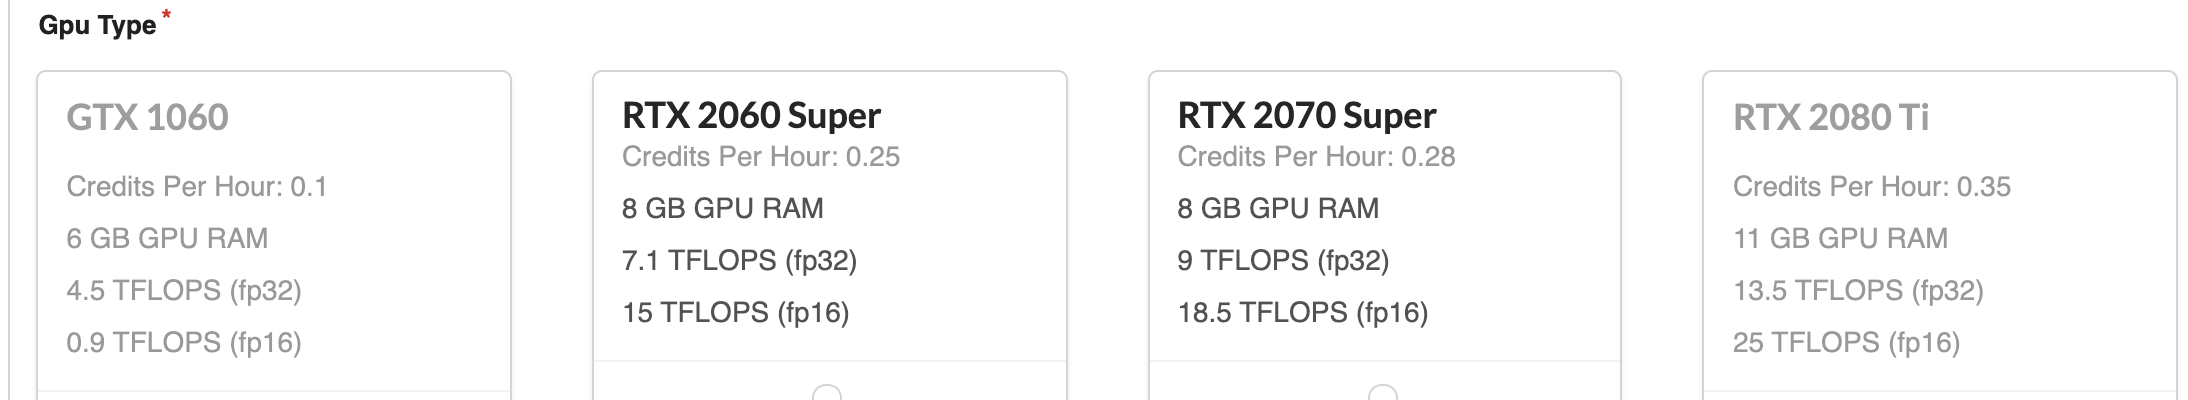

# 9. Offer - https://www.trainml.ai/gbdc-offer/


In [ ]:
# Finally all this is available in a git repo I setup 
# Here's is the link - https://github.com/vsistla/gpu-training